In [324]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import glob
import matplotlib.pyplot as plt

In [325]:
# LOAD AND PREPROCESS THE DATA
# Load the dataset

file_paths = glob.glob('Data/CSV/*.csv')


# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the list of file paths and read each CSV into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';')
    dfs.append(df)

# Concatenate all the DataFrames into one
concatenated_df = pd.concat(dfs, ignore_index=True) 

print(concatenated_df)

length_df = len(concatenated_df)
print("Length of the dataset: ", length_df)

      correct/anomalous          ra        dec  parallax      pmra     pmdec  \
0                     1  219.951395 -60.972606  0.368673 -2.559203 -2.056463   
1                     1  219.790777 -60.981536       NaN       NaN       NaN   
2                     1  219.803709 -60.975396       NaN       NaN       NaN   
3                     1  219.778267 -60.976624       NaN       NaN       NaN   
4                     1  219.785612 -60.974524       NaN       NaN       NaN   
...                 ...         ...        ...       ...       ...       ...   
7401                  1   28.845468  89.462600       NaN       NaN       NaN   
7402                  1   27.815499  89.479682  0.360444 -0.155736  1.833010   
7403                  1   27.681935  89.472701  0.724468  6.799206 -1.938184   
7404                  1   30.878262  89.482899  0.183544  3.281337  0.156618   
7405                  1   31.594724  89.483904  0.158085 -3.238124  3.092111   

      astrometric_excess_noise      ruw

In [326]:
# PREPROCESSING
df_cleaned = concatenated_df.dropna()

length_df_cleaned = len(df_cleaned)
print("Length of the cleaned dataset: ", length_df_cleaned)

Length of the cleaned dataset:  6051


In [327]:
def augment_parallax_errors(df, anomaly_rate, error_factor):
    """
    Augments the parallax values with errors to simulate anomalies.
    
    Parameters:
    df (DataFrame): A DataFrame containing the original Gaia data.
    anomaly_rate (float): The fraction of total objects that should be anomalous.
    error_factor (float): A factor that determines the magnitude of the error introduced.

    Returns:
    DataFrame: A DataFrame with the augmented parallax data.
    """
    # Make a copy of the DataFrame to avoid altering the original data
    augmented_df = df.copy()
    
    # Calculate the number of objects to alter based on the anomaly rate
    num_anomalies = int(len(df) * anomaly_rate)
    
    # Select random indices for introducing anomalies
    anomaly_indices = np.random.choice(df.index, size=num_anomalies, replace=False)
    
    # Introduce errors in the parallax values
    # The error can be a random value that depends on the error_factor and the current parallax value
    augmented_df.loc[anomaly_indices, 'parallax'] += error_factor * np.random.randn(num_anomalies) * augmented_df.loc[anomaly_indices, 'parallax']
    
    # Mark the augmented objects as anomalous
    augmented_df.loc[anomaly_indices, 'correct/anomalous'] = 0  # Assuming 0 represents anomalous in your dataset
    
    return augmented_df

# Assuming you have a DataFrame `gaia_data` with your data
# augmented_data = augment_parallax_errors(gaia_data, anomaly_rate=0.1, error_factor=0.5)
# print(augmented_data.head())

In [328]:
augmented_df = augment_parallax_errors(df_cleaned, anomaly_rate=0.1, error_factor=100.0)

In [329]:
# Function to print class distribution
def print_class_distribution(y_data):
    count_class_0 = sum(y_data == 0)
    count_class_1 = sum(y_data == 1)
    total = len(y_data)
    print("Class 0: {:.2f}%, Class 1: {:.2f}%".format((count_class_0 / total) * 100, (count_class_1 / total) * 100))

In [330]:
# Splitting the augmented dataset into initial training set and unlabeled pool
initial_train_size = 50
# Randomly sample initial training data
initial_train_indices = np.random.choice(a=augmented_df.index, size=initial_train_size, replace=False)
X_initial = augmented_df.drop('correct/anomalous', axis=1).loc[initial_train_indices]
y_initial = augmented_df['correct/anomalous'].loc[initial_train_indices]
# Create the pool by excluding the initial training data
X_pool = augmented_df.drop('correct/anomalous', axis=1).drop(initial_train_indices)
y_pool = augmented_df['correct/anomalous'].drop(initial_train_indices)

In [331]:
# Initialize and train the Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_initial, y_initial)

RandomForestClassifier()

In [332]:
 # # TODO
        # -  make a graph that shows which combination of epochs and nr of datapoints gives the best result
        # -  make a graph that shows the accuracy of the model, using the above combination, each time with different number of epochs 
        # -  zorgt een acquisition function ervoor dat de training data meer gebalanced wordt?

In [349]:
# UNCERTAINTY SAMPLING
# Active learning loop (acquisition function)
# Example: Adding 350 most uncertain points from the pool to the training set
total_data_points = 6000
augmented_df = augment_parallax_errors(df_cleaned, anomaly_rate=0.1, error_factor=100.0)
X_pool_initial = augmented_df.drop('correct/anomalous', axis=1)
y_pool_initial = augmented_df['correct/anomalous']

# Dictionary to store the balance of the training set for each combination
balance_results = {}

# for i in range(1, total_data_points):
# for i in [1, 50, 100, 250, 500, 1000]:
for i in [1, 50, 100, 150]:
    if total_data_points % i == 0:
        X_pool = X_pool_initial.copy()
        y_pool = y_pool_initial.copy()
        X_train = X_initial.copy()
        y_train = y_initial.copy()

        epoch_balances = {}
        
        for epoch in range(i):
            data_points_evaluated = (epoch + 1) * (total_data_points // i)
            # print('epochs', i, 'nr of datapoints', total_data_points/i)
            # Predict probabilities on the unlabeled data
            probabilities = rfc.predict_proba(X_pool)

            # Calculate uncertainty and select the most uncertain data points
            ## MAX PROBABILITY
            uncertainty = abs(probabilities[:, 1] - 0.5)

            ## ENNTORPY
            # epsilon = 1e-10  # A small constant
            # uncertainty = -np.sum(probabilities * np.log(probabilities + epsilon), axis=1)
            
            n_most_uncertain =  int(total_data_points/i)  # Number of points to acquire in each iteration
            most_uncertain_indices = np.argsort(uncertainty)[-n_most_uncertain:]

            # Add these points to the training set
            most_uncertain_points = X_pool.iloc[most_uncertain_indices]
            most_uncertain_labels = y_pool.iloc[most_uncertain_indices]
            X_train_extended = pd.concat([X_train, most_uncertain_points])
            y_train_extended = pd.concat([y_train, most_uncertain_labels])

            # Print class distribution
            # print_class_distribution(y_train_extended)

            # Calculate the balance score and add it to epoch_balances
            class_distribution = y_train_extended.value_counts(normalize=True)
            balance = abs(class_distribution[0] - class_distribution[1])
            epoch_balances[data_points_evaluated] = balance

            # Retrain the model on the extended training set
            rfc.fit(X_train_extended, y_train_extended)

            # Update the pool by excluding the most uncertain points
            # Use boolean indexing for this
            mask = X_pool.index.isin(most_uncertain_points.index)
            X_pool = X_pool[~mask]
            y_pool = y_pool[~mask]

        # Evaluate the balance of the training set
        class_distribution = y_train_extended.value_counts(normalize=True)
        print('epochs', i, 'nr of datapoints', total_data_points/i)
        print_class_distribution(y_train_extended)
        # print("epoch_balances", epoch_balances)

        # Calculate the balance score
        balance = abs(class_distribution[0] - class_distribution[1])
        balance_results[(i, int(total_data_points/i))] = balance

# Analyze the balance results to find the best combination
best_combination = min(balance_results, key=balance_results.get)
print("Best combination (Epochs, Data points per epoch):", best_combination)
print("Balance score:", balance_results[best_combination]) #  lower balance score indicates a more balanced class distribution.



epochs 1 nr of datapoints 6000.0
Class 0: 9.37%, Class 1: 90.63%
epochs 50 nr of datapoints 120.0
Class 0: 72.35%, Class 1: 27.65%
epochs 100 nr of datapoints 60.0
Class 0: 57.27%, Class 1: 42.73%
epochs 150 nr of datapoints 40.0
Class 0: 47.78%, Class 1: 52.22%
Best combination (Epochs, Data points per epoch): (150, 40)
Balance score: 0.04444444444444445


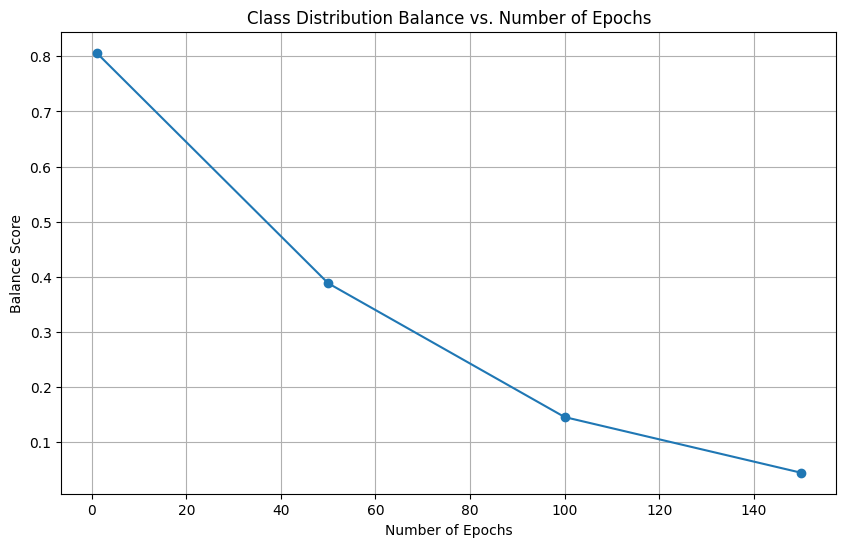

In [344]:
# make a graph that shows which combination of epochs and nr of datapoints gives the best result
# Extracting epochs and balance scores from the balance_results dictionary
epochs = [key[0] for key in balance_results.keys()]
balance_scores = [balance_results[key] for key in balance_results.keys()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, balance_scores, marker='o')
plt.xlabel('Number of Epochs')
plt.ylabel('Balance Score')
plt.title('Class Distribution Balance vs. Number of Epochs')
plt.grid(True)
plt.show()

TypeError: object of type 'numpy.float64' has no len()

In [280]:
# # UNCERTAINTY SAMPLING
# # Active learning loop (acquisition function)
# # Example: Adding 350 most uncertain points from the pool to the training set
# for _ in range(100):  # Run 7 iterations (50 points each iteration)
#     # Predict probabilities on the unlabeled data
#     probabilities = rfc.predict_proba(X_pool)

#     # Calculate uncertainty and select the most uncertain data points
#     uncertainty = abs(probabilities[:, 1] - 0.5)
#     n_most_uncertain = 60  # Number of points to acquire in each iteration
#     most_uncertain_indices = uncertainty.argsort()[:n_most_uncertain]

#     # Add these points to the training set
#     most_uncertain_points = X_pool.iloc[most_uncertain_indices]
#     most_uncertain_labels = y_pool.iloc[most_uncertain_indices]
#     X_train_extended = pd.concat([X_initial, most_uncertain_points])
#     y_train_extended = pd.concat([y_initial, most_uncertain_labels])

#     # Print class distribution
#     print_class_distribution(y_train_extended)

#     # Retrain the model on the extended training set
#     rfc.fit(X_train_extended, y_train_extended)

#     # Update the pool by excluding the most uncertain points
#     # Use boolean indexing for this
#     mask = X_pool.index.isin(most_uncertain_points.index)
#     X_pool = X_pool[~mask]
#     y_pool = y_pool[~mask]

Class 0: 60.00%, Class 1: 40.00%
Class 0: 13.64%, Class 1: 86.36%
Class 0: 54.55%, Class 1: 45.45%
Class 0: 48.18%, Class 1: 51.82%
Class 0: 46.36%, Class 1: 53.64%
Class 0: 20.00%, Class 1: 80.00%
Class 0: 54.55%, Class 1: 45.45%
Class 0: 36.36%, Class 1: 63.64%
Class 0: 40.00%, Class 1: 60.00%
Class 0: 53.64%, Class 1: 46.36%
Class 0: 29.09%, Class 1: 70.91%
Class 0: 44.55%, Class 1: 55.45%
Class 0: 26.36%, Class 1: 73.64%
Class 0: 36.36%, Class 1: 63.64%
Class 0: 9.09%, Class 1: 90.91%
Class 0: 8.18%, Class 1: 91.82%
Class 0: 5.45%, Class 1: 94.55%
Class 0: 5.45%, Class 1: 94.55%
Class 0: 6.36%, Class 1: 93.64%
Class 0: 5.45%, Class 1: 94.55%
Class 0: 5.45%, Class 1: 94.55%
Class 0: 5.45%, Class 1: 94.55%
Class 0: 5.45%, Class 1: 94.55%
Class 0: 6.36%, Class 1: 93.64%
Class 0: 6.36%, Class 1: 93.64%
Class 0: 6.36%, Class 1: 93.64%
Class 0: 6.36%, Class 1: 93.64%
Class 0: 9.09%, Class 1: 90.91%
Class 0: 8.18%, Class 1: 91.82%
Class 0: 7.27%, Class 1: 92.73%
Class 0: 6.36%, Class 1: 9

In [ ]:
# Active learning loop (acquisition function)
# # Example: Adding 350 most uncertain points from the pool to the training set
# for _ in range(100):  # Run 7 iterations (50 points each iteration)
#     # Predict probabilities on the unlabeled data
#     probabilities = rfc.predict_proba(X_pool)

#     # Calculate uncertainty and select the most uncertain data points
#     uncertainty = abs(probabilities[:, 1] - 0.5)
#     n_most_uncertain = 60  # Number of points to acquire in each iteration
#     most_uncertain_indices = uncertainty.argsort()[:n_most_uncertain]

#     # Add these points to the training set
#     most_uncertain_points = X_pool.iloc[most_uncertain_indices]
#     most_uncertain_labels = y_pool.iloc[most_uncertain_indices]
#     X_train_extended = pd.concat([X_initial, most_uncertain_points])
#     y_train_extended = pd.concat([y_initial, most_uncertain_labels])

#     # Print class distribution
#     print_class_distribution(y_train_extended)

#     # Retrain the model on the extended training set
#     rfc.fit(X_train_extended, y_train_extended)

#     # Update the pool by excluding the most uncertain points
#     # Use boolean indexing for this
#     mask = X_pool.index.isin(most_uncertain_points.index)
#     X_pool = X_pool[~mask]
#     y_pool = y_pool[~mask]

In [281]:
# Loading a separate test set from another CSV file
test_df = pd.read_csv('Data/Capella5arcmin.csv', sep=';')
length_df = len(test_df)
print("Length of the dataset: ", length_df)

df_cleaned = test_df.dropna()
length_df_cleaned = len(df_cleaned)
print("Length of the cleaned dataset: ", length_df_cleaned)

column_names = df_cleaned.columns
print(column_names)

augmented_test_df = augment_parallax_errors(df_cleaned, anomaly_rate=0.5, error_factor=100.0)
X_test = augmented_test_df.drop('correct/anomalous', axis=1)
y_test = augmented_test_df['correct/anomalous']

Length of the dataset:  921
Length of the cleaned dataset:  741
Index(['correct/anomalous', 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'astrometric_excess_noise', 'ruwe', 'phot_g_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp'],
      dtype='object')


In [282]:
# Evaluate the model on the new test set
y_pred = rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5870445344129555

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29       370
           1       0.55      1.00      0.71       371

    accuracy                           0.59       741
   macro avg       0.77      0.59      0.50       741
weighted avg       0.77      0.59      0.50       741

